<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [131]:
import pandas as pd 
import numpy as np
import math
import datetime
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer

from sklearn import neighbors, tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, CatBoost
import lightgbm as lgb

from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
import wordcloud
from wordcloud import WordCloud
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller

In [132]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates =[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates =[0])


data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [133]:
data['num_orders'] = data['num_orders'].astype('int16')

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int16
dtypes: int16(1)
memory usage: 258.8 KB


In [135]:
data = data.resample("1H").sum()

In [136]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

# def make_features(data, max_lag, rolling_mean_size):
   
#     for lag in range(1, max_lag + 1):
#         data['lag_{}'.format(lag)] = data['PJME_MW'].shift(lag)
#     data['rolling_mean'] = data['PJME_MW'].shift(rolling_mean_size-3).rolling(rolling_mean_size).mean()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

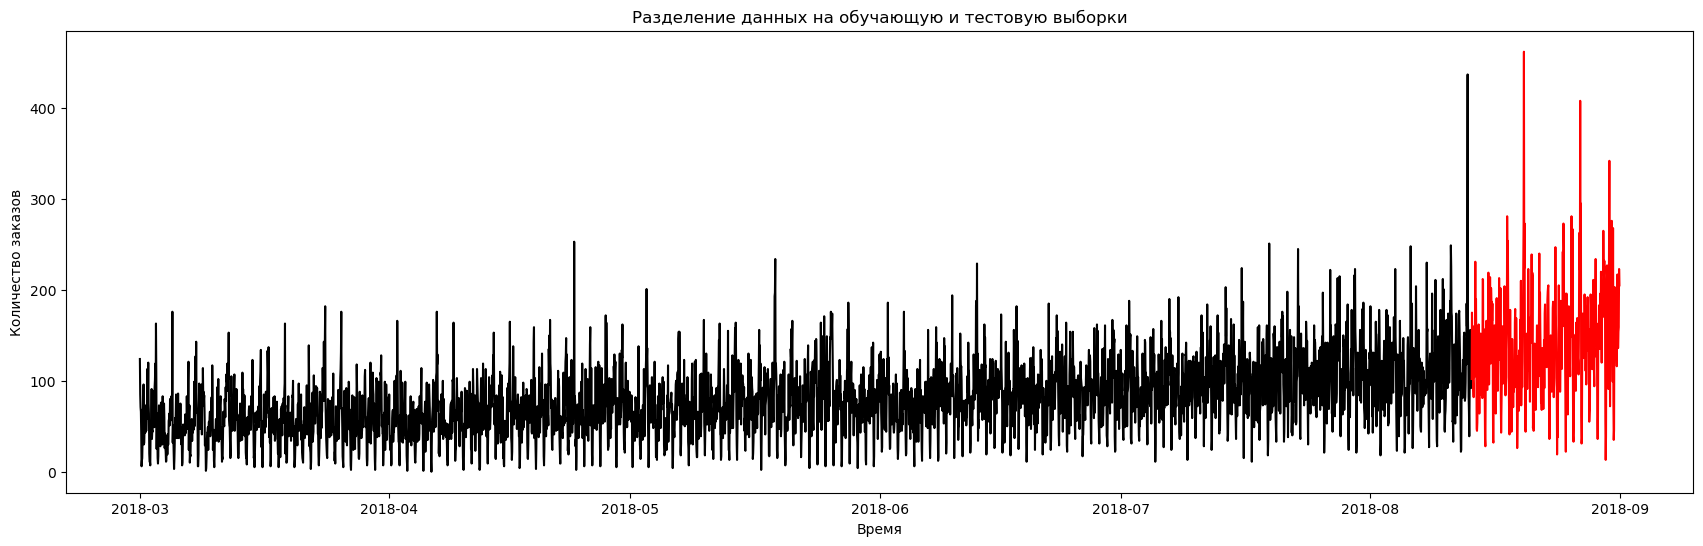

In [137]:
plt.figure(figsize = (21,6))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.show()

<AxesSubplot:xlabel='datetime'>

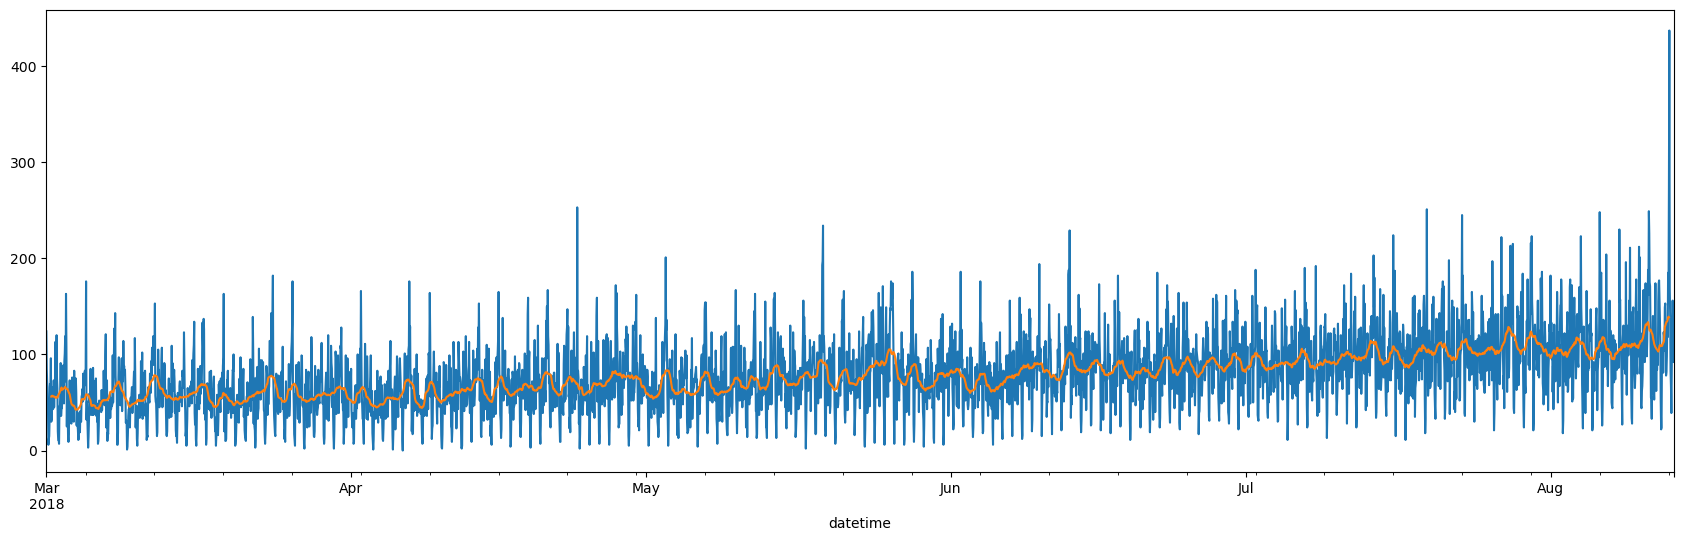

In [138]:
y_train.plot(figsize = (21,6))
decomposed = seasonal_decompose(y_train) 
decomposed.trend.plot()


<AxesSubplot:xlabel='datetime'>

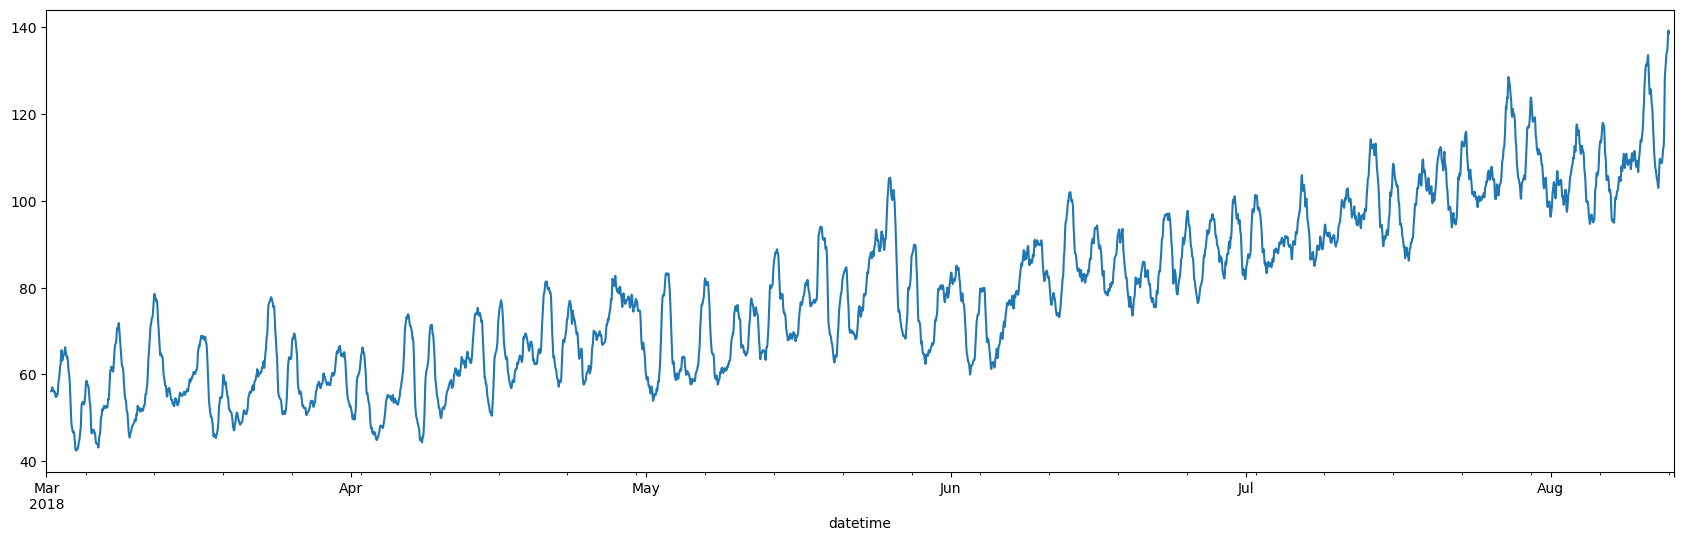

In [139]:
decomposed.trend.plot(figsize = (21,6))

<AxesSubplot:xlabel='datetime'>

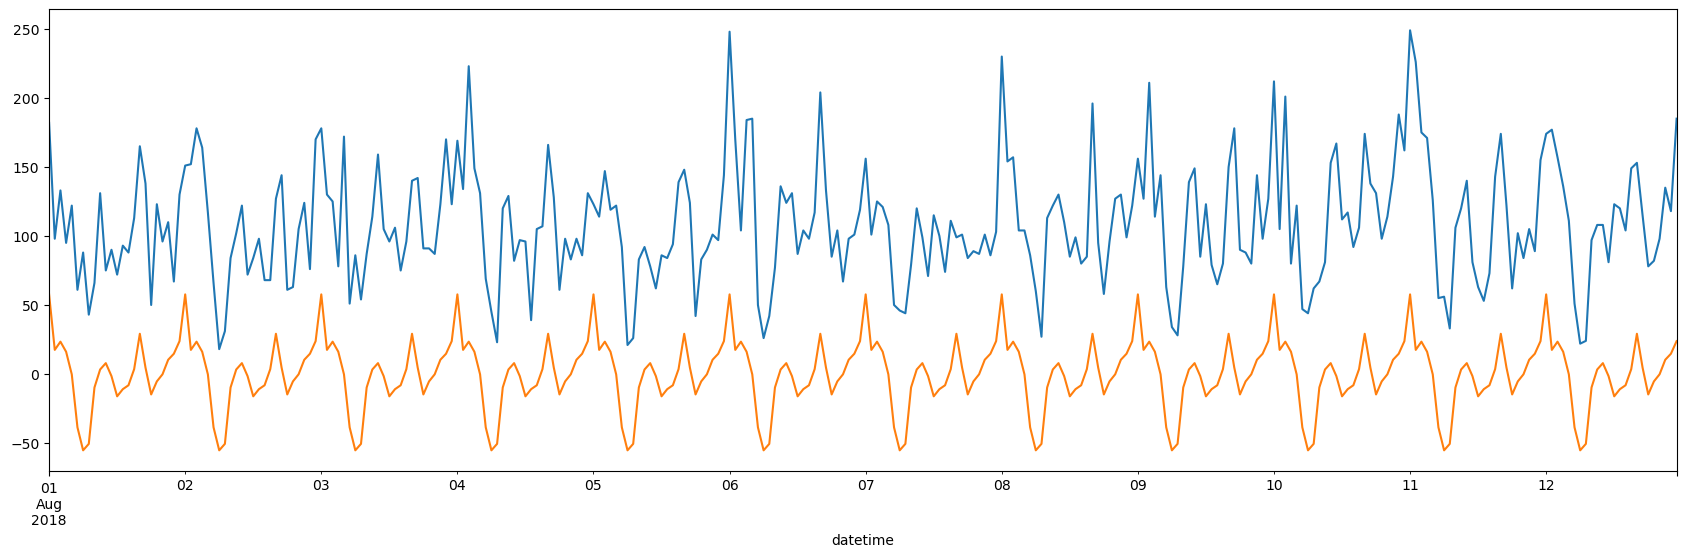

In [140]:
y_train['2018-08-01':'2018-08-12'].plot()
decomposed.seasonal['2018-08-01':'2018-08-12'].plot(figsize = (21,6))


<AxesSubplot:xlabel='datetime'>

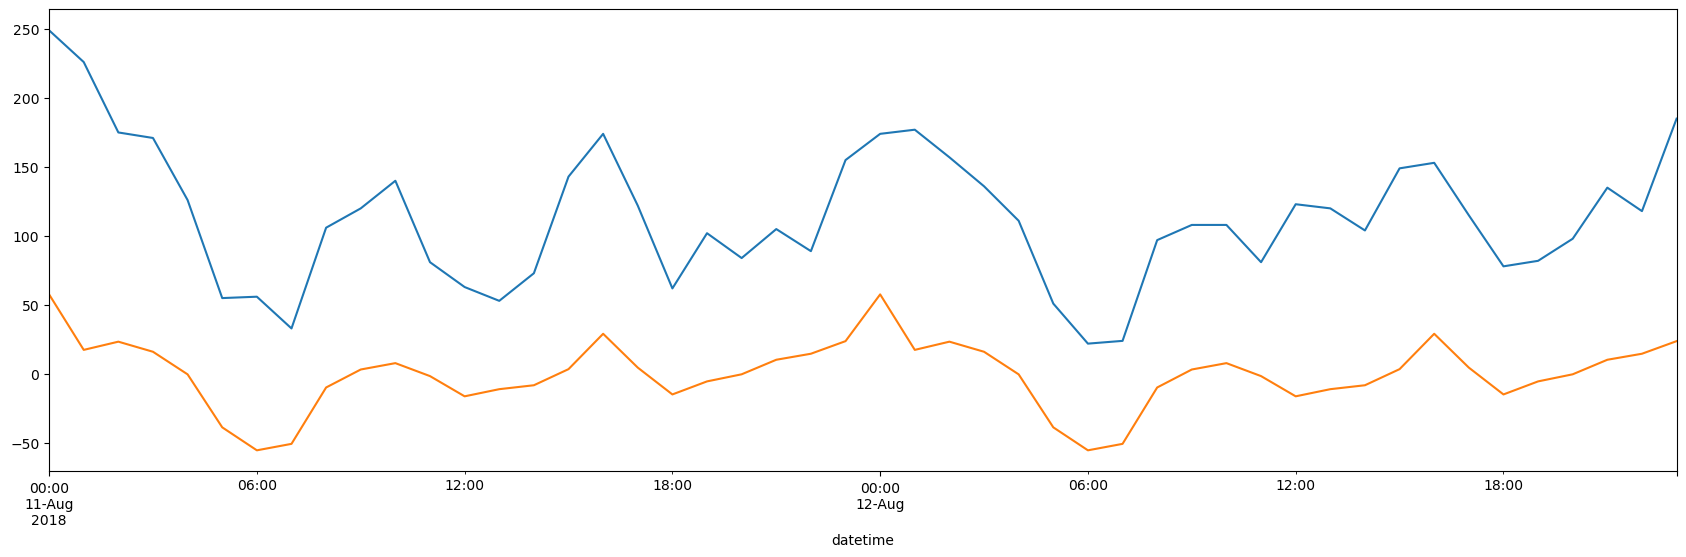

In [141]:
y_train['2018-08-11':'2018-08-12'].plot()
decomposed.seasonal['2018-08-11':'2018-08-12'].plot(figsize = (21,6))

<AxesSubplot:xlabel='datetime'>

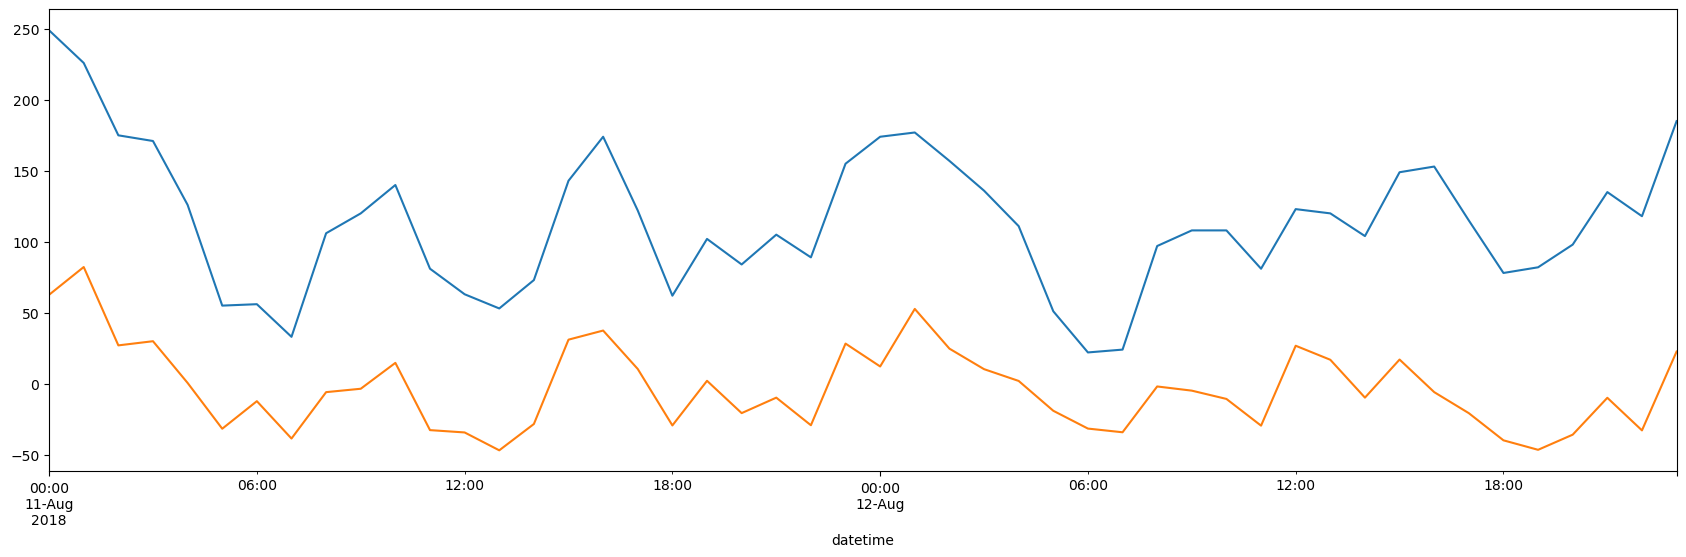

In [142]:
y_train['2018-08-11':'2018-08-12'].plot()
decomposed.resid['2018-08-11':'2018-08-12'].plot(figsize = (21,6))

## Анализ

Модель SARIMA
делал по лекции от Data Mining in Action
https://www.youtube.com/watch?v=u433nrxdf5k&t=3548s

In [143]:
p_value = adfuller(y_train)[1]
print('p =', p_value)

p = 0.0007322730527364563


Первым шагом дифференцируем сезонность. поскольку у нас сезонность равняется суткам, берем смещение 24 часа

p = 7.575565783641764e-28


TypeError: 'float' object is not subscriptable

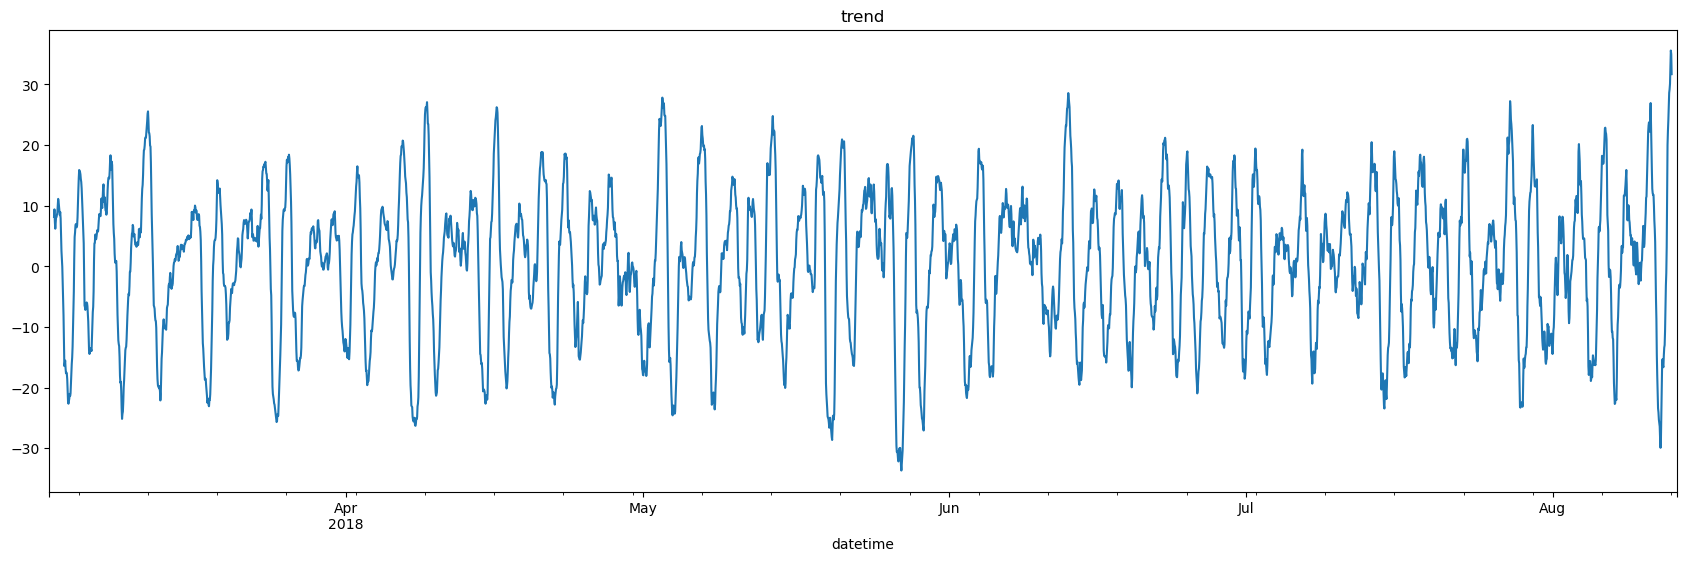

In [144]:
train_dif_1 = y_train - y_train.shift(24)
train_dif_1.dropna(inplace=True)
decomposed_dif_1 = seasonal_decompose(train_dif_1)
decomposed_dif_1.trend.plot(figsize=(21,6), title='trend')
p_value = adfuller(train_dif_1)[1]
print('p =', p_value)
print('std =',np.std(train_dif_1)[0])

p = 0.0
std = 39.084570194728414


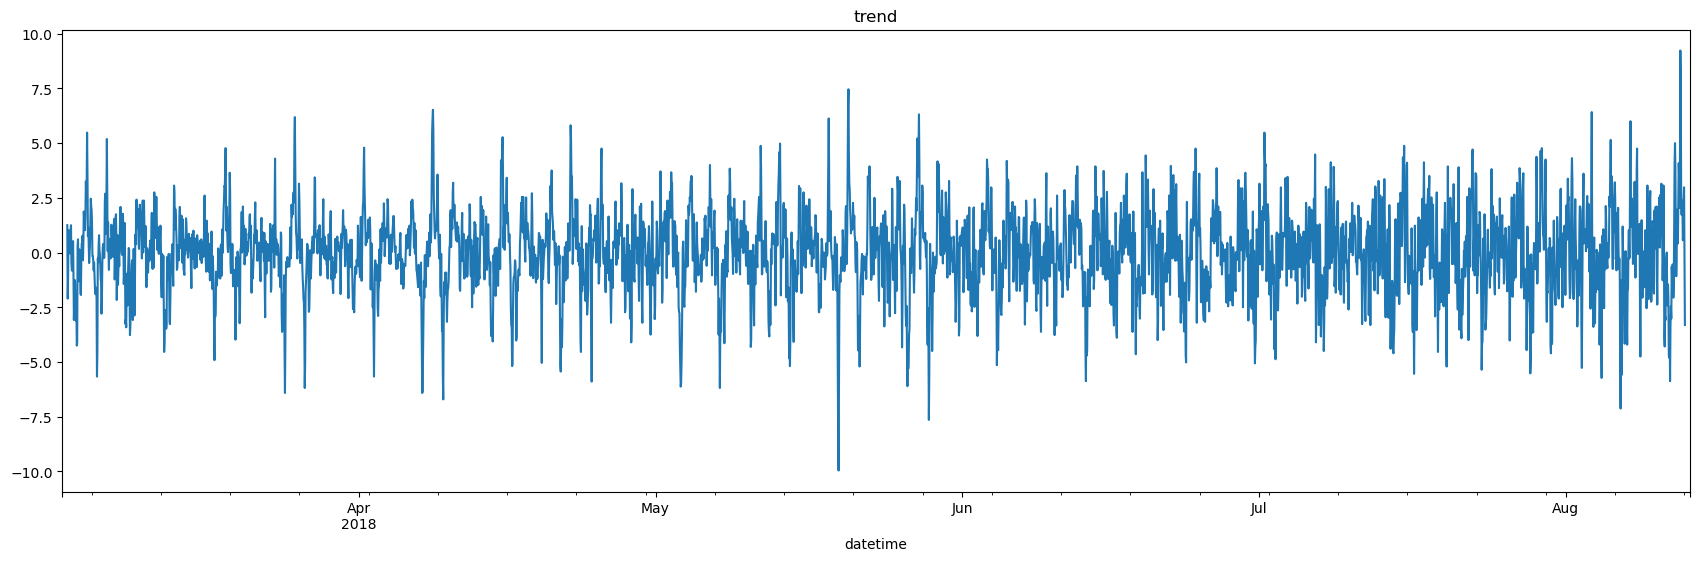

In [ ]:
train_dif_2 = train_dif_1 - train_dif_1.shift(1)
train_dif_2.dropna(inplace=True)
decomposed_dif_2 = seasonal_decompose(train_dif_2)
decomposed_dif_2.trend.plot(figsize=(21,6), title='trend')
p_value = adfuller(train_dif_2)[1]
print('p =', p_value)
print('std =',np.std(train_dif_2)[0])

p = 1.2116373982872665e-28
std = 67.22263855601801


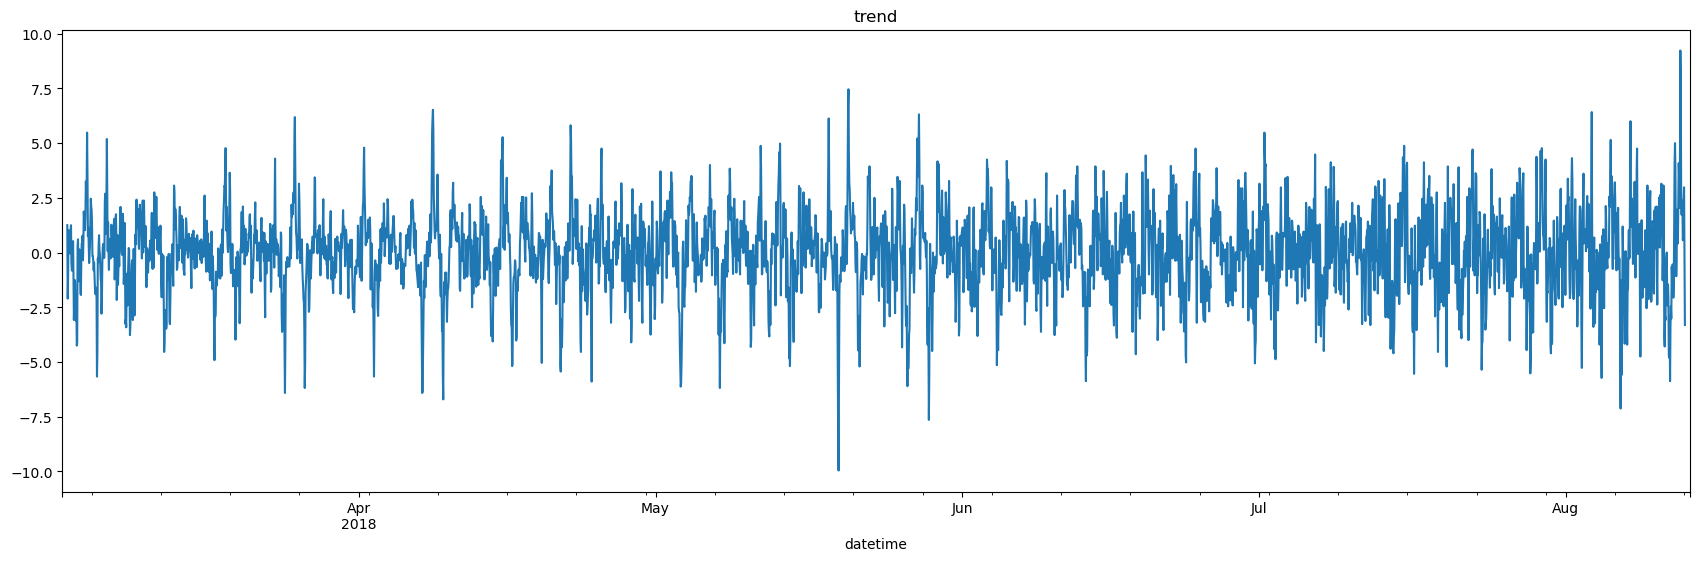

In [145]:
train_dif_3 = train_dif_2 - train_dif_2.shift(1)
train_dif_3.dropna(inplace=True)
decomposed_dif_3 = seasonal_decompose(train_dif_2)
decomposed_dif_3.trend.plot(figsize=(21,6), title='trend')
p_value = adfuller(train_dif_3)[1]
print('p =', p_value)
print('std =',np.std(train_dif_3)[0])

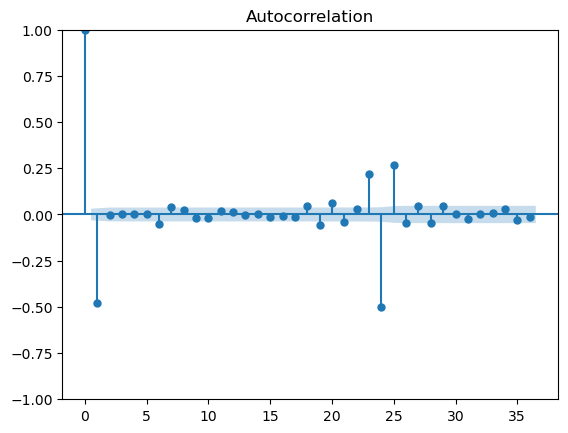

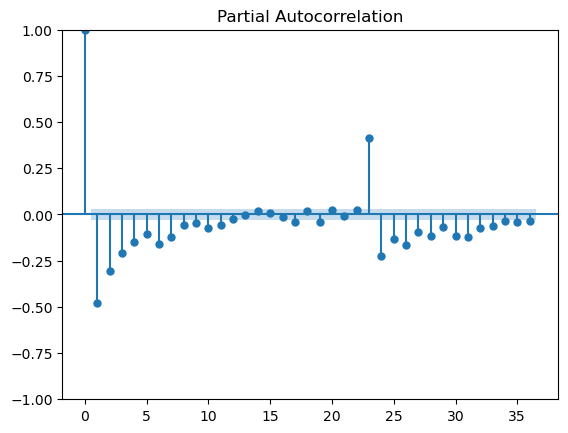

In [146]:
plot_acf(train_dif_2)
plt.show()
plot_pacf(train_dif_2)
plt.show()


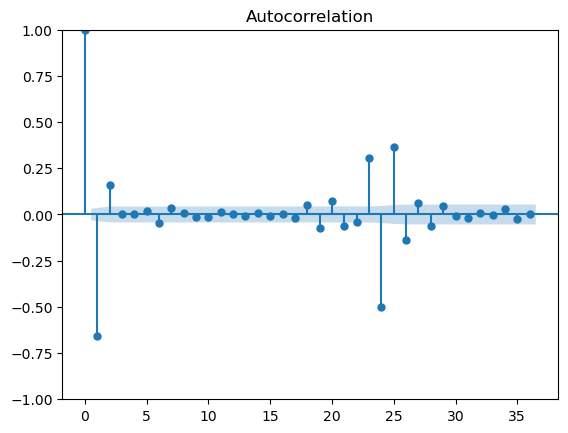

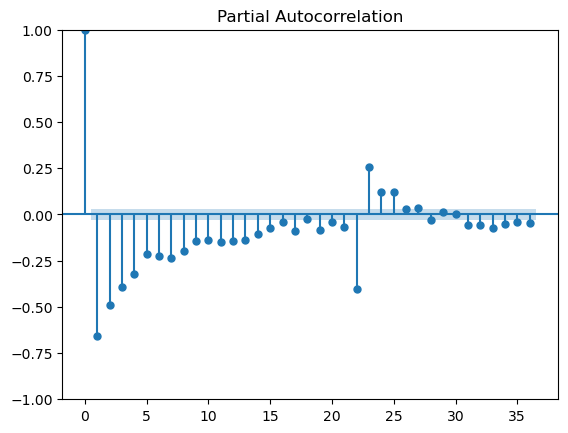

In [147]:
plot_acf(train_dif_3)
plt.show()
plot_pacf(train_dif_3)
plt.show()

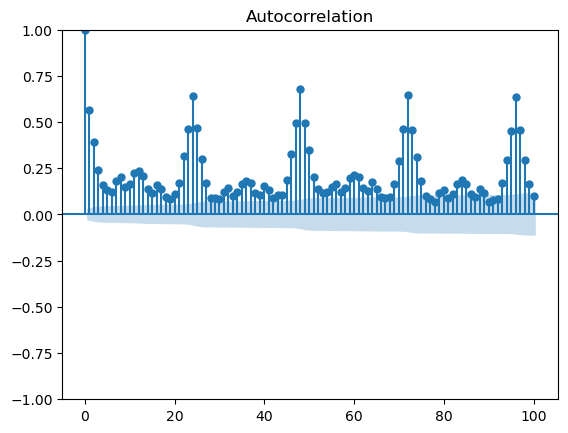

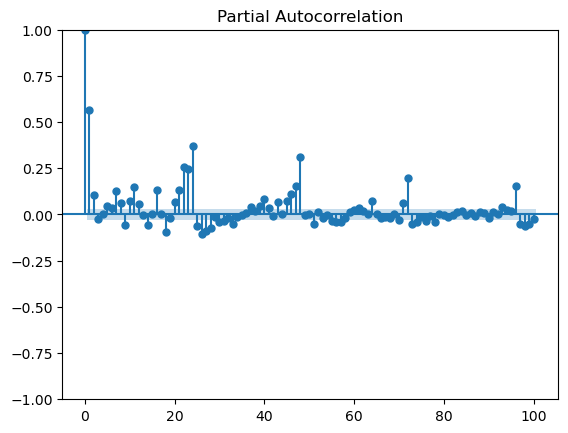

In [148]:
plot_acf(y_train, lags=100)
plt.show()
plot_pacf(y_train, lags=100)
plt.show()

SARIMA(p,d,q)(P,D,Q)m
d =1
D=1

p = 8
q = 2

Q=1

P= 6

## Обучение

In [149]:
#### Модель SARIMAX5145

In [150]:
from pmdarima import auto_arima

SARIMA(p,d,q)(P,D,Q)m
d =1
D=1

p = 8
q = 2

Q=1

P= 6

In [15]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(y_train, 
                order = (8, 1, 2), 
                seasonal_order = (6, 1, 1, 24))

# применим метод fit
result = model.fit()



In [121]:
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                 3974
Model:             SARIMAX(8, 1, 2)x(6, 1, [1], 24)   Log Likelihood              -17673.701
Date:                              Tue, 14 Mar 2023   AIC                          35383.402
Time:                                      20:25:01   BIC                          35496.464
Sample:                                  03-01-2018   HQIC                         35423.506
                                       - 08-13-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8944      0.064    -14.078      0.000      -1.019      -0.770
ar.L2          0.17

In [18]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(y_train)

# и закончится в конце тестового
end = len(y_train) + len(y_test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

2018-08-13 14:00:00     94.845739
2018-08-13 15:00:00    121.403660
2018-08-13 16:00:00    188.307727
2018-08-13 17:00:00    136.907530
2018-08-13 18:00:00     90.424153
                          ...    
2018-08-31 19:00:00    102.139220
2018-08-31 20:00:00    105.210927
2018-08-31 21:00:00    134.906820
2018-08-31 22:00:00    126.787226
2018-08-31 23:00:00    157.432396
Freq: H, Name: predicted_mean, Length: 442, dtype: float64

In [22]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print(mean_squared_error(y_test, predictions))

# и RMSE
print(np.sqrt(mean_squared_error(y_test, predictions)))

1847.4311352440977
42.9817535152313


In [160]:
from sktime.forecasting.arima import AutoARIMA
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


forecaster = AutoARIMA(sp=24)
forecaster.fit(y_train)
y_pred = forecaster.predict(start, end)

print(mean_squared_error(y_test, y_pred))

# и RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))


TypeError: X must be either None, or in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynbIf you think X is already in an sktime supported input format, run sktime.datatypes.check_raise(X, mtype) to diagnose the error, where mtype is the string of the type specification you want for X. Possible mtype specification strings are as follows. "For Hierarchical scitype: ['pd_multiindex_hier']. 

## Тестирование

In [154]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))


63.78900123113787


In [155]:
model = CatBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Learning rate set to 0.050916
0:	learn: 37.7825415	total: 115ms	remaining: 1m 55s
1:	learn: 36.9452784	total: 118ms	remaining: 58.8s
2:	learn: 36.1983516	total: 120ms	remaining: 39.8s
3:	learn: 35.4640795	total: 122ms	remaining: 30.3s
4:	learn: 34.6972207	total: 124ms	remaining: 24.7s
5:	learn: 34.1756894	total: 127ms	remaining: 21.1s
6:	learn: 33.4961705	total: 130ms	remaining: 18.4s
7:	learn: 32.8908909	total: 131ms	remaining: 16.3s
8:	learn: 32.3788435	total: 134ms	remaining: 14.7s
9:	learn: 31.8882834	total: 136ms	remaining: 13.5s
10:	learn: 31.3792225	total: 138ms	remaining: 12.4s
11:	learn: 30.8990140	total: 140ms	remaining: 11.5s
12:	learn: 30.4815897	total: 142ms	remaining: 10.7s
13:	learn: 30.0881513	total: 143ms	remaining: 10.1s
14:	learn: 29.6885584	total: 145ms	remaining: 9.52s
15:	learn: 29.4093744	total: 147ms	remaining: 9.02s
16:	learn: 29.0965758	total: 148ms	remaining: 8.59s
17:	learn: 28.7965294	total: 150ms	remaining: 8.19s
18:	learn: 28.5041317	total: 152ms	remainin

In [158]:
model = MLPRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

66.20841215239209


In [152]:
X_test

,year,month,day,dayofweek,hour
datetime,,,,,
2018-08-13 14:00:00,2018,8,13,0,14
2018-08-13 15:00:00,2018,8,13,0,15
2018-08-13 16:00:00,2018,8,13,0,16
2018-08-13 17:00:00,2018,8,13,0,17
2018-08-13 18:00:00,2018,8,13,0,18
...,...,...,...,...,...
2018-08-31 19:00:00,2018,8,31,4,19
2018-08-31 20:00:00,2018,8,31,4,20
2018-08-31 21:00:00,2018,8,31,4,21


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48